# NSSP Projet 2

## PART 3 : Regression for joint angles

### Import

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter, sosfiltfilt, welch
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif, SelectKBest, RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from matplotlib.patches import Rectangle

### Load subject 1

In [74]:
data = loadmat("S1_E1_A1.mat")
print("Dataset variables:")
for key in data.keys():
    if not key.startswith("__"):
        print(key)

Dataset variables:
subject
exercise
emg
acc
gyro
mag
glove
stimulus
repetition
restimulus
rerepetition


### 1 Visualize, preprocess and split the data

In [75]:
emg = data["emg"]
print("EMG data dimension: {}".format(emg.shape))
print("EMG data type: {}".format(type(emg)))

stimulus = data["restimulus"] 
repetition = data["rerepetition"] 

print("Stimuli {} , Repetitions {}".format(stimulus.shape,repetition.shape))

# -1 because 0 is the resting condition
n_stimuli = len(np.unique(stimulus)) - 1 
# -1 because 0 is not a repetition
n_repetitions = len(np.unique(repetition)) - 1 
n_channels = emg.shape[1]

print(f'Number of movements : {n_stimuli}') 
print(f'Number of repetitions : {n_repetitions}') 

EMG data dimension: (2292526, 16)
EMG data type: <class 'numpy.ndarray'>
Stimuli (2292526, 1) , Repetitions (2292526, 1)
Number of movements : 9
Number of repetitions : 10


In [76]:
number_of_samples_per_trial = np.zeros((n_stimuli, n_repetitions))

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        
        idx = np.logical_and(stimulus == stimuli_idx+1, repetition == repetition_idx+1)
        number_of_samples_per_trial[stimuli_idx, repetition_idx] = np.sum(idx.astype(int))

print("Number of sample per trials \n Mean : {} \n std : {} \n min : {} \n max: {}".format(number_of_samples_per_trial.mean(),number_of_samples_per_trial.std(),number_of_samples_per_trial.min(),number_of_samples_per_trial.max()))

Number of sample per trials 
 Mean : 12270.566666666668 
 std : 3680.100780775802 
 min : 5667.0 
 max: 20935.0


#### Visualize signals

/var/folders/3s/zlrwdymn79q5z4m7dgq_nk440000gn/T/ipykernel_19688/3653886863.py:12: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0.5)


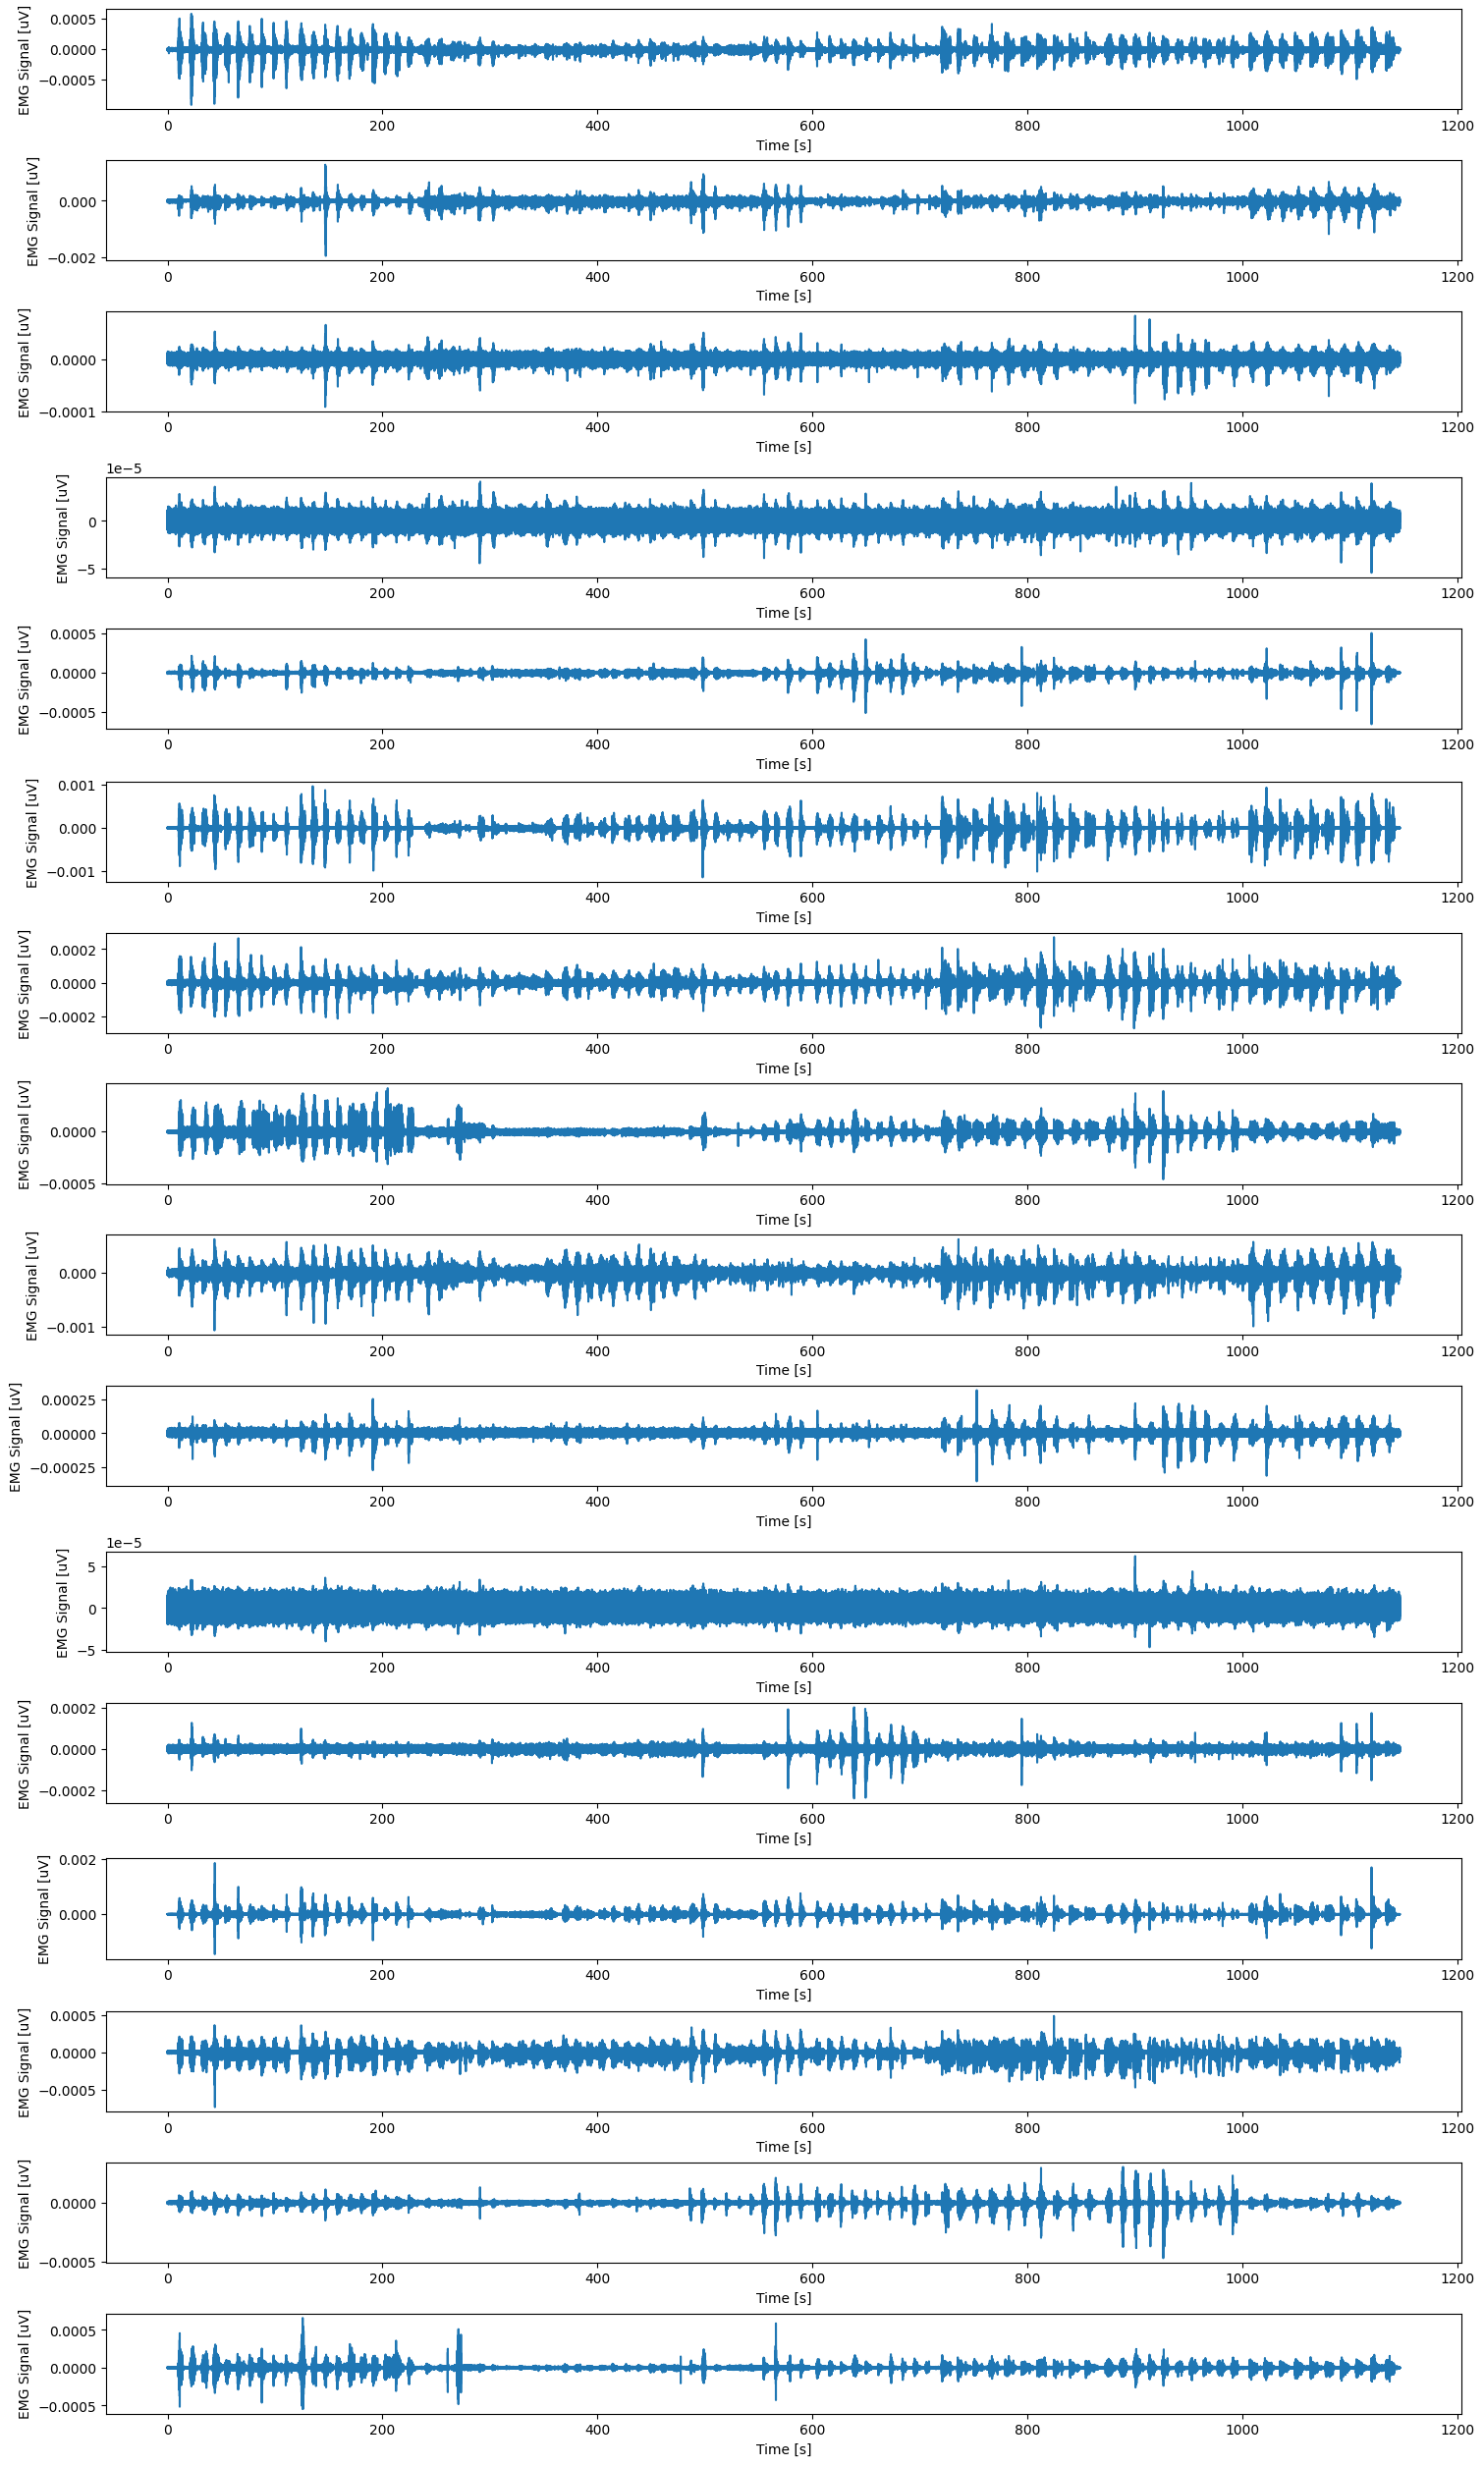

In [77]:
n_channels = emg.shape[1]
fs = 2000
time_steps = np.arange(0,emg.shape[0]/fs, 1/fs) 

fig, ax = plt.subplots(n_channels, 1, constrained_layout=True, figsize=(15, 25))
for channel_idx in range(n_channels):
    ax[channel_idx].plot(time_steps, emg[:, channel_idx])
    ax[channel_idx].set_xlabel("Time [s]")
    ax[channel_idx].set_ylabel("EMG Signal [uV]")

# Adjust spacing between subplots
fig.subplots_adjust(hspace=0.5)

#### Preprocessing

In [78]:
# apply bandpass filter
bandpass_cutoff_frequencies_Hz = (5, 500) 
sos = butter(N=4, Wn=bandpass_cutoff_frequencies_Hz, fs=fs, btype="bandpass", output="sos") 
emg_filtered = sosfiltfilt(sos, emg.T).T 

powergrid_noise_frequencies_Hz = [harmonic_idx*50 for harmonic_idx in range(1,3)] # removing 50Hz noise and its harmonics

for noise_frequency in powergrid_noise_frequencies_Hz:
    sos = butter(N=4, Wn=(noise_frequency - 2, noise_frequency + 2), fs=fs, btype="bandstop", output="sos")
    emg_filtered = sosfiltfilt(sos, emg_filtered.T).T

Text(0.5, 1.0, 'Power Spectral Density plot in Log scale')

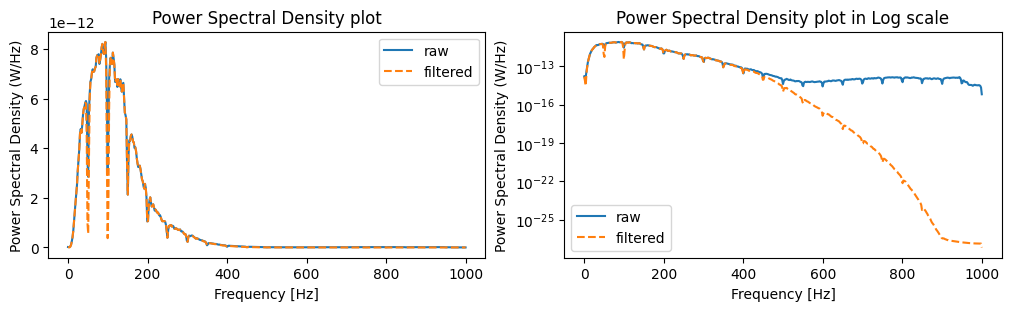

In [79]:
#Use Welch's method for power spectral density estimation, it reduces the variance of the estimate.
freqs_pre, Pxx_pre = welch(emg[:, 0], fs=fs, nperseg=1064)
freqs_post, Pxx_post = welch(emg_filtered[:, 0],fs = fs,  nperseg=1064)

fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3))
ax[0].plot(freqs_pre, Pxx_pre, label="raw")
ax[0].plot(freqs_post, Pxx_post, linestyle="--", label="filtered")
ax[0].legend()
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Power Spectral Density (W/Hz)")
ax[0].set_title("Power Spectral Density plot")

ax[1].semilogy(freqs_pre, Pxx_pre, label="raw")
ax[1].semilogy(freqs_post, Pxx_post, linestyle="--", label="filtered")
ax[1].legend()
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Power Spectral Density (W/Hz)")
ax[1].set_title("Power Spectral Density plot in Log scale")

/var/folders/3s/zlrwdymn79q5z4m7dgq_nk440000gn/T/ipykernel_19688/3014404993.py:11: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0.5)


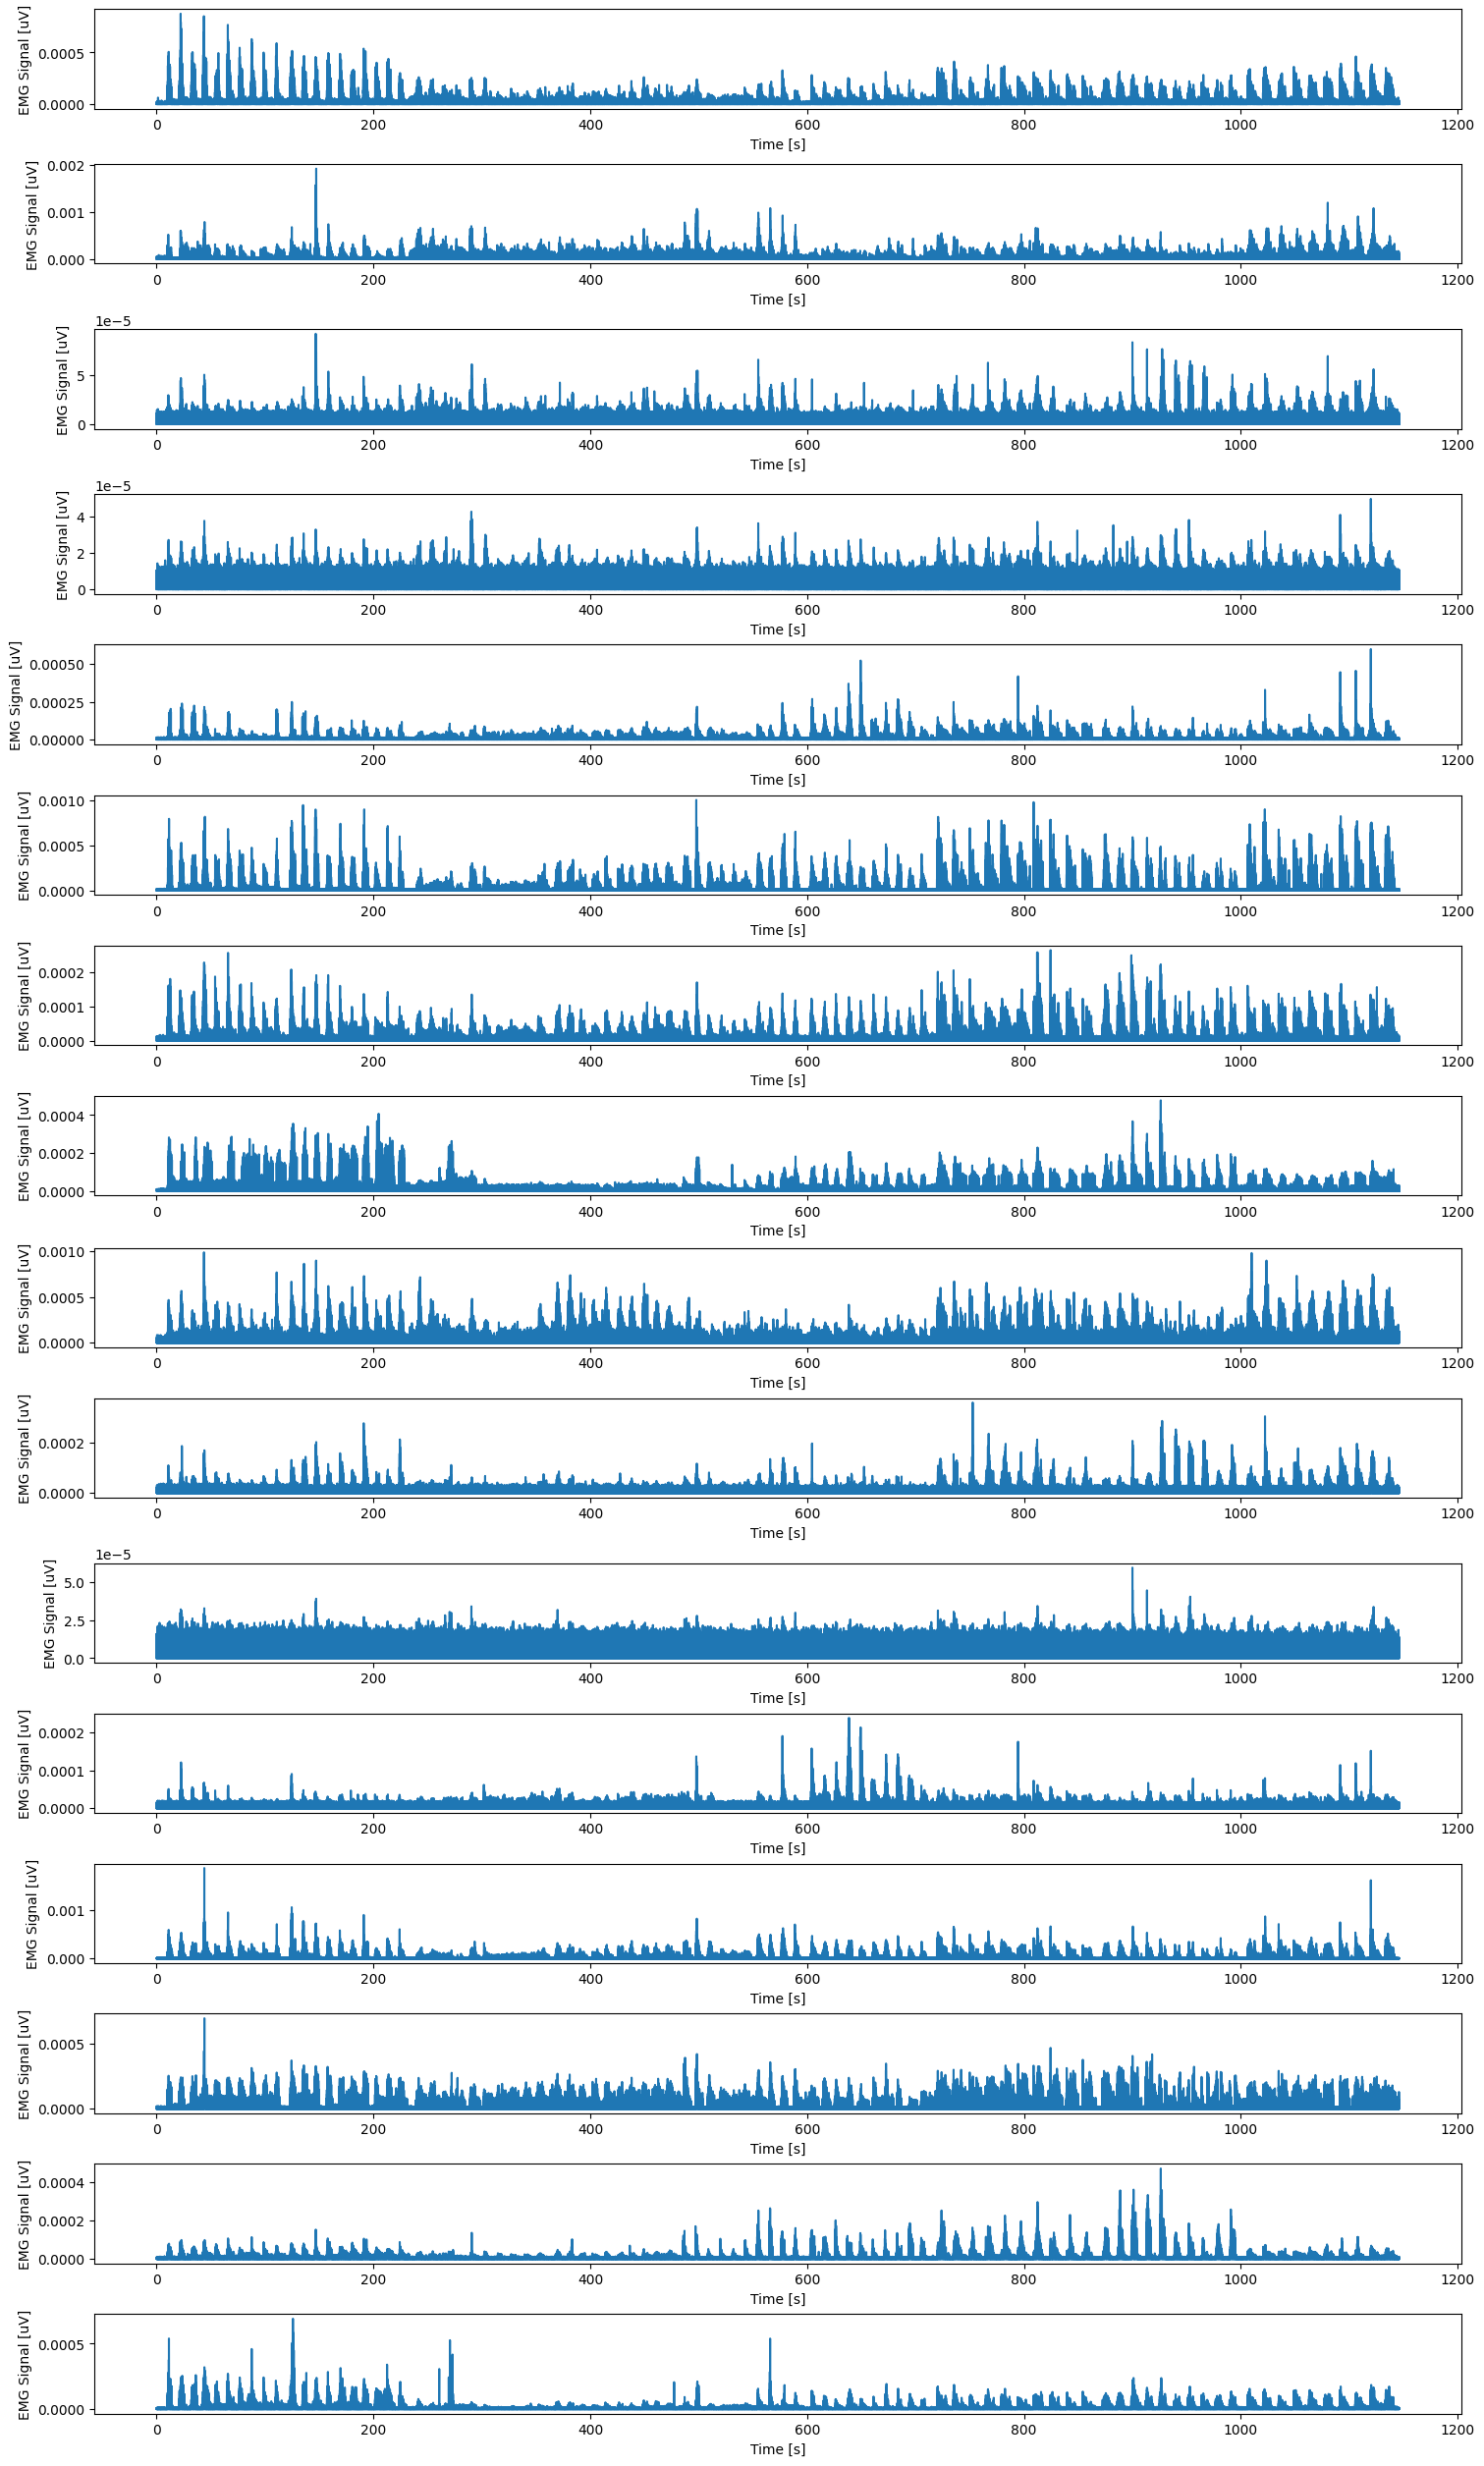

In [80]:
# Rectify signals
emg_rectified = np.abs(emg_filtered) # Rectify the signal

fig, ax = plt.subplots(n_channels, 1, constrained_layout=True, figsize=(15, 25))
for channel_idx in range(n_channels):
    ax[channel_idx].plot(time_steps, emg_rectified[:, channel_idx])
    ax[channel_idx].set_xlabel("Time [s]")
    ax[channel_idx].set_ylabel("EMG Signal [uV]")

# Adjust spacing between subplots
fig.subplots_adjust(hspace=0.5)

#### Visualize all channels 

In [81]:
# only regressing on finger joint 3,6,8,11 and 14
#glove_data_index = data["glove"][[3,6,8,11,14]]
glove_data_index = data["glove"][:, [3,6,8,11,14]]
print("Glove data dimension: {}".format(glove_data_index.shape))
print("Glove data type: {}".format(type(glove_data_index)))

Glove data dimension: (2292526, 5)
Glove data type: <class 'numpy.ndarray'>


/var/folders/3s/zlrwdymn79q5z4m7dgq_nk440000gn/T/ipykernel_19688/2532663295.py:36: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Text(0.5, 0.98, 'EMG Signals and Finger Angles')

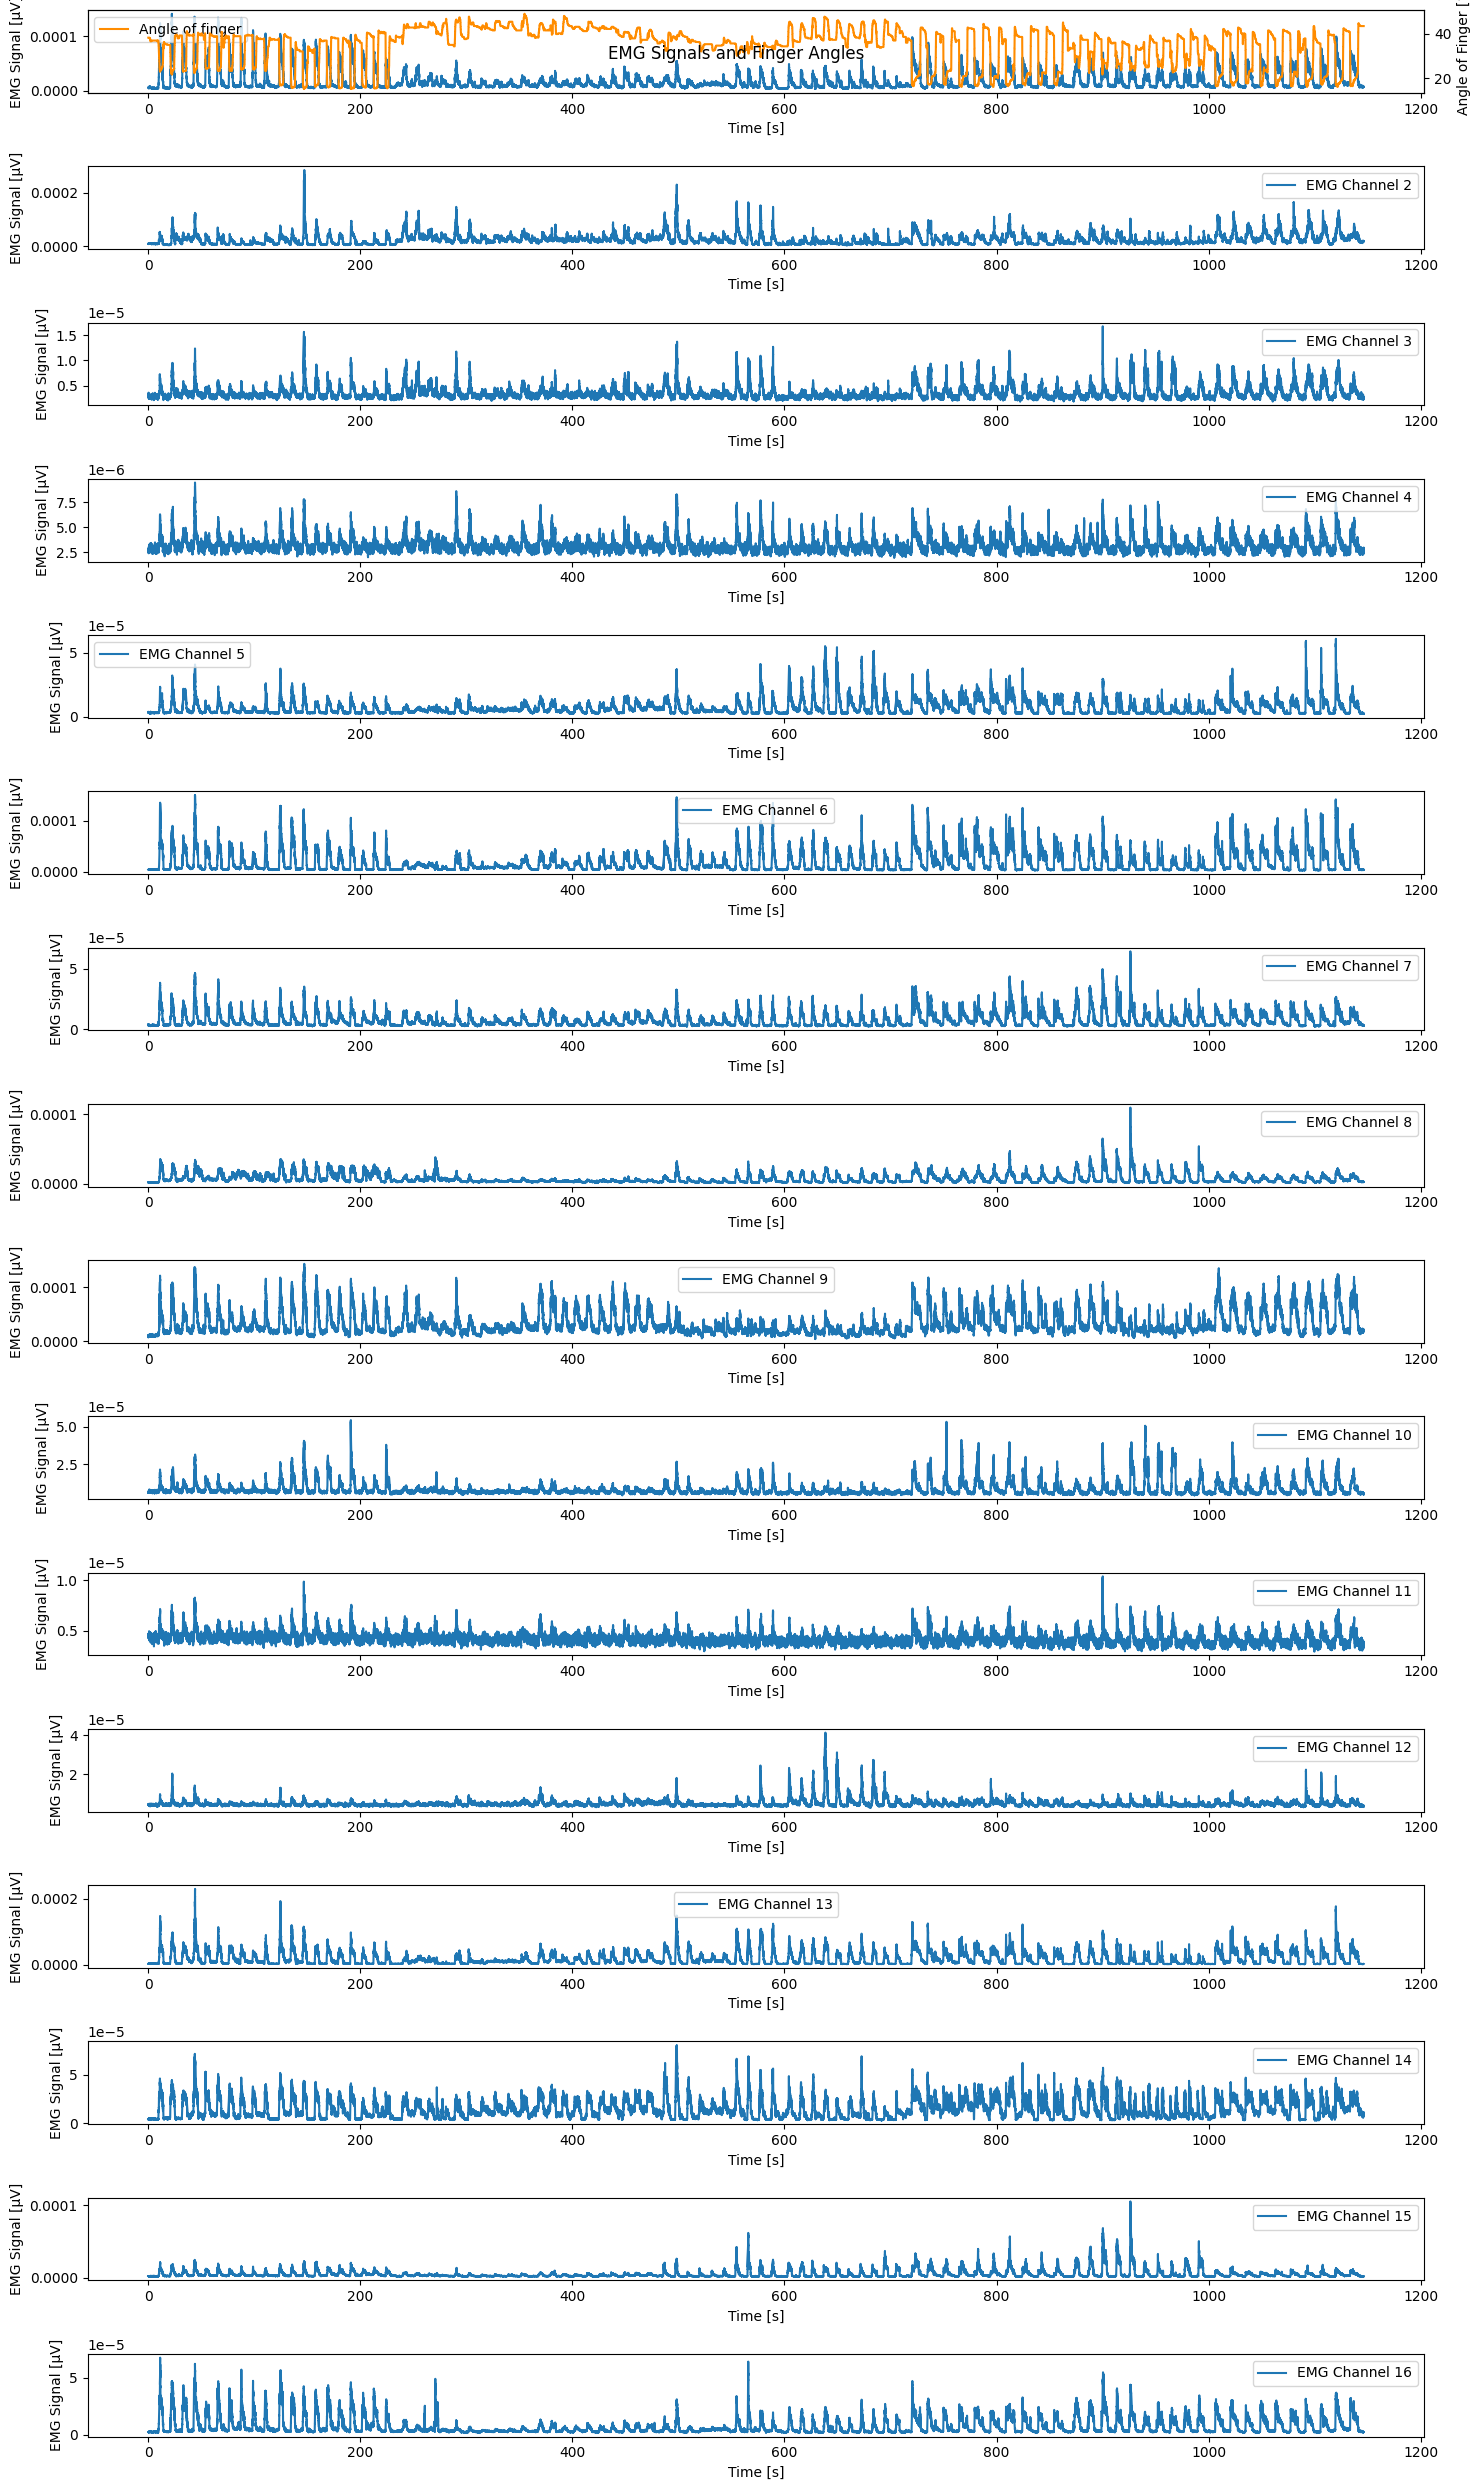

In [82]:
mov_mean_length = 400
mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length
emg_envelopes = convolve1d(emg_rectified, weights=mov_mean_weights, axis=0) # convolve1d the rectified signal with the moving average weights

# Create the figure and axes for the EMG channels
fig, ax = plt.subplots(n_channels, 1, constrained_layout=True, figsize=(15, 25))

# Create a second y-axis to plot the finger angle (outside the loop)
finger_angle_ax = ax[0].twinx()  # Use the same x-axis for all channels

# Plot finger angle data on the second y-axis
finger_angle_ax.plot(time_steps, glove_data_index[:, 0], color="darkorange", label="Angle of finger")
finger_angle_ax.set_ylabel("Angle of Finger [°]")
finger_angle_ax.grid(False)

# Plot the EMG signals for each channel
for channel_idx in range(n_channels):
    ax[channel_idx].plot(time_steps, emg_envelopes[:, channel_idx])
    ax[channel_idx].set_xlabel("Time [s]")
    ax[channel_idx].set_ylabel("EMG Signal [µV]")
    #ax[channel_idx].set_ylim(0, 0.00025) 
    ax[channel_idx].legend([f"EMG Channel {channel_idx+1}"])

# Get handles and labels for the legends
emg_handles, emg_labels = ax[0].get_legend_handles_labels()
finger_angle_handles, finger_angle_labels = finger_angle_ax.get_legend_handles_labels()

# Combine handles and labels for the legend
combined_handles = emg_handles + finger_angle_handles
combined_labels = emg_labels + finger_angle_labels

# Create a single legend
ax[0].legend(combined_handles, combined_labels, loc='upper left')

# Adjust layout to ensure everything fits properly
plt.tight_layout()
plt.suptitle("EMG Signals and Finger Angles")

# fig, ax = plt.subplots(n_channels, 1, constrained_layout=True, figsize=(15, 25))
# for channel_idx in range(n_channels):
#     ax[channel_idx].plot(time_steps, emg_envelopes[:, channel_idx])
#     ax[channel_idx].set_xlabel("Time [s]")
#     ax[channel_idx].set_ylabel("EMG Signal [uV]")
#     ax[channel_idx].set_ylim(0, 0.00025)
# plt.suptitle("EMG envelopes")

# # Adjust spacing between subplots
# fig.subplots_adjust(hspace=0.5)

#### Split the data and extract features

In [83]:
def build_dataset_from_ninapro(emg, stimulus, repetition, features):
    # Calculate the number of unique stimuli and repetitions, subtracting 1 to exclude the resting condition
    n_stimuli = np.unique(stimulus).size - 1
    n_repetitions = np.unique(repetition).size - 1
    # Total number of samples is the product of stimuli and repetitions
    n_samples = n_stimuli * n_repetitions
    
    # Number of channels in the EMG data
    n_channels = emg.shape[1]
    # Calculate the total number of features by summing the number of channels for each feature
    n_features = sum(n_channels for feature in features)
    
    # Initialize the dataset and labels arrays with zeros
    dataset = np.zeros((n_samples, n_features))
    labels = np.zeros(n_samples)
    current_sample_index = 0
    
    # Loop over each stimulus and repetition to extract features
    for i in range(n_stimuli):
        for j in range(n_repetitions):
            # Assign the label for the current sample
            labels[current_sample_index] = i + 1
            # Calculate the current sample index based on stimulus and repetition
            current_sample_index = i * n_repetitions + j
            current_feature_index = 0
            # Select the time steps corresponding to the current stimulus and repetition
            selected_tsteps = np.logical_and(stimulus == i + 1, repetition == j + 1).squeeze()
            
            # Loop over each feature function provided
            for feature in features:
                # Determine the indices in the dataset where the current feature will be stored
                selected_features = np.arange(current_feature_index, current_feature_index + n_channels)
                # Apply the feature function to the selected EMG data and store the result
                dataset[current_sample_index, selected_features] = feature(emg[selected_tsteps, :])
                # Update the feature index for the next feature
                current_feature_index += n_channels

            # Move to the next sample
            current_sample_index += 1
            
    # Return the constructed dataset and corresponding labels
    return dataset, labels

In [89]:
# Mean absolute value (MAV)
mav = lambda x: np.mean(np.abs(x), axis=0)

# Standard Deviation (STD)
std = lambda x: np.std(x, axis=0)

# Maximum absolute Value (MaxAV)
maxav = lambda x: np.max(np.abs(x), axis=0)

# Root mean square (RMS)
rms = lambda x: np.sqrt(np.mean(x**2, axis=0))

# Waveform length (WL)
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)

# Slope sign changes (SSC)
ssc = lambda x: np.sum(
    ((x[1:-1] - x[:-2]) * (x[2:] - x[1:-1])) < 0,
    axis=0
)

# Using the dataset function with the implemented features
dataset, labels = build_dataset_from_ninapro(
    emg=emg_envelopes,
    stimulus=stimulus,
    repetition=repetition,
    features=[mav, std, maxav, rms, wl, ssc]  # Include all features once implemented
)

print(f"dataset dimension: {dataset.shape}")
print(f"labels dimension: {labels.shape}")

dataset dimension: (90, 96)
labels dimension: (90,)


In [90]:
train_size = int(0.7 * len(dataset))  # 70% for training, 30% for testing

X_train, X_test = dataset[:train_size], dataset[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Normalizing the data with a mean of 0 and a standard deviation of 1
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)  
X_test_z = scaler.transform(X_test)   

print("Train shape {}".format(X_train_z.shape))
print("Test shape {}".format(X_test_z.shape))


Train shape (62, 96)
Test shape (28, 96)


### 2 Perform sliding window

In [91]:
emg_window_length_sec = 128e-3  # [s]
incremental_window_length_sec = 50e-3  # [s]

In [87]:
def extract_time_windows_regression(EMG: np.ndarray, Label: np.ndarray, fs: int, win_len: int, step: int):
# This function is used to cut the time windows from the raw EMG 
# It return a lists containing the EMG of each time window.
# It also returns the target corresponding to the time of the end of the window
    """
    This function is defined to perform an overlapping sliding window 
    :param EMG: Numpy array containing the data
    :param Label: Numpy array containing the targets
    :param fs: the sampling frequency of the signal
    :param win_len: The size of the windows (in seconds)
    :param step: The step size between windows (in seconds)

    :return: A Numpy array containing the windows
    :return: A Numpy array containing the targets aligned for each window
    :note: The lengths of both outputs are the same
    """
    
    n,m = EMG.shape
    win_len = int(win_len*fs)
    start_points = np.arange(0,n-win_len,int(step*fs))
    end_points = start_points + win_len

    EMG_windows = np.zeros((len(start_points),win_len,m))
    Labels_window = np.zeros((len(start_points),win_len,Label.shape[1]))
    for i in range(len(start_points)):
        EMG_windows[i,:,:] = EMG[start_points[i]:end_points[i],:]
        Labels_window[i,:,:] = Label[start_points[i]:end_points[i],:]
    

    return EMG_windows, Labels_window

In [92]:
from sklearn.model_selection import train_test_split
# extract over lapping time windows on the whole dataset before splitting the dataset into train, validation and test
EMG_windows, Labels_windows = extract_time_windows_regression(emg_envelopes, glove_data_index, fs, emg_window_length_sec, incremental_window_length_sec)

# randomly pick data for train, validation and test
EMG_train_windows, EMG_test_windows, Labels_train_windows, Labels_test_windows = train_test_split(EMG_windows, Labels_windows, test_size=0.2, random_state=151)

print(f"EMG train data shape: {EMG_train_windows.shape}, Train label shape: {Labels_train_windows.shape}")
print(f"EMG test data shape: {EMG_test_windows.shape}, Test label shape: {Labels_test_windows.shape}")

EMG train data shape: (18338, 256, 16), Train label shape: (18338, 256, 5)
EMG test data shape: (4585, 256, 16), Test label shape: (4585, 256, 5)


### 3 Extract set of features 

In [105]:
# in paper : wilson amplitude, 4e order auto regressive coeffs, waveform length, log-variance, slope sign change
def extract_features(EMG_windows: np.ndarray, Labels_windows: np.ndarray):
    """
    This function is defined to extract the mean and standard deviation of each window
    :param EMG_windows: A Numpy array containing the windows
    :return: A Numpy array containing the mean and standard deviation of each window and the mean of the labels window
    """
    EMG_wilson_amp = np.ptp(EMG_windows, axis=1)
    print("Wilson Amplitude shape:", EMG_wilson_amp.shape)
    
    EMG_wave_length = np.sum(np.abs(np.diff(EMG_windows, axis=1)), axis=1)
    print("Waveform Length shape:", EMG_wave_length.shape)

    EMG_log_var = np.log(np.var(EMG_windows, axis=1) + 1e-8)
    print("Log Variance shape:", EMG_log_var.shape)

    EMG_mean = np.mean(EMG_windows, axis=1)
    print("Mean shape:", EMG_mean.shape)

    EMG_std = np.std(EMG_windows, axis=1)
    print("Standard deviaton shape:", EMG_std.shape)

    Labels_mean = np.mean(Labels_windows,axis=1)

    EMG_extracted_features = np.concatenate((EMG_wilson_amp, EMG_wave_length, EMG_log_var, EMG_mean, EMG_std), axis=1)
    return EMG_extracted_features, Labels_mean

In [106]:
EMG_train_extracted_features, Labels_train_mean = extract_features(EMG_train_windows,Labels_train_windows)
EMG_test_extracted_features, Labels_test_mean = extract_features(EMG_test_windows,Labels_test_windows)

print("EMG train extracted features shape: {}, Fingler labels feature shape:{}".format(EMG_train_extracted_features.shape, Labels_train_mean.shape))
print("EMG test extracted features shape: {}, Fingler labels feature shape:{}".format(EMG_test_extracted_features.shape, Labels_test_mean.shape))

Wilson Amplitude shape: (18338, 16)
Waveform Length shape: (18338, 16)
Log Variance shape: (18338, 16)
Mean shape: (18338, 16)
Standard deviaton shape: (18338, 16)
Wilson Amplitude shape: (4585, 16)
Waveform Length shape: (4585, 16)
Log Variance shape: (4585, 16)
Mean shape: (4585, 16)
Standard deviaton shape: (4585, 16)
EMG train extracted features shape: (18338, 80), Fingler labels feature shape:(18338, 5)
EMG test extracted features shape: (4585, 80), Fingler labels feature shape:(4585, 5)


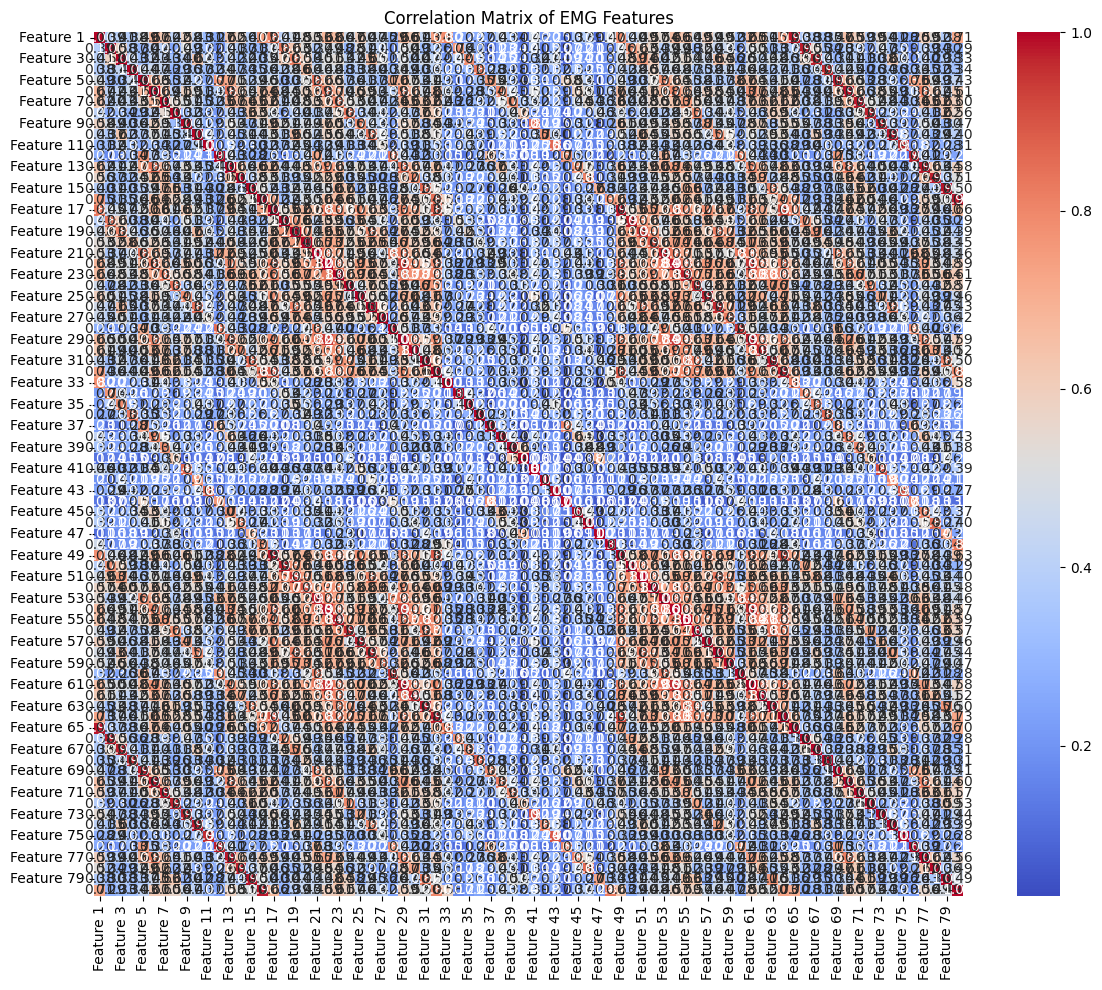

In [108]:
# Normalize the features using StandardScaler
scaler = StandardScaler()
EMG_train_normalized = scaler.fit_transform(EMG_train_extracted_features)
EMG_test_normalized = scaler.transform(EMG_test_extracted_features) 

# Use pandas DataFrame to improve readability
feature_names = [f"Feature {i+1}" for i in range(80)]  # Naming your 80 features
df_train = pd.DataFrame(EMG_train_normalized, columns=feature_names)

# Calculate the correlation matrix between features
correlation_matrix = df_train.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of EMG Features")
plt.tight_layout()
plt.show()

### 4 Perform regression

#### tentative Wiener Filter Regression comme dans paper

In [109]:
# Wiener Filter Regression Implementation
def wiener_filter_regression(X, y, filter_length=300):
    """
    Apply Wiener filter regression to predict y from X.
    
    :param X: The input features (EMG data).
    :param y: The target labels (finger angles).
    :param filter_length: The length of the filter (the number of taps).
    :return: The estimated weights and the predicted output.
    """
    
    # Add a bias term (column of ones) to the input features
    X = np.hstack([np.ones((X.shape[0], 1)), X])  # Shape (num_samples, num_features + 1)
    
    # Compute the Wiener filter weights using the normal equation:
    # W = (X.T * X)^-1 * X.T * y
    XTX = np.dot(X.T, X)
    XTX_inv = np.linalg.inv(XTX + 1e-8 * np.eye(XTX.shape[0]))  # Add a small regularization term to avoid singularity
    XTy = np.dot(X.T, y)
    
    # Wiener filter weights (including bias term)
    W = np.dot(XTX_inv, XTy)
    
    # Predict using the Wiener filter weights
    y_pred = np.dot(X, W)
    
    return W, y_pred

# Train the Wiener filter regression model on the training data
W, y_train_pred = wiener_filter_regression(EMG_train_normalized, Labels_train_mean)

# Test the Wiener filter model on the test data
y_test_pred = np.dot(np.hstack([np.ones((EMG_train_normalized.shape[0], 1)), EMG_test_normalized]), W)

# Compute the Mean Squared Error (MSE) on the test set
mse_test = np.mean((y_test_pred - Labels_test_mean) ** 2)
print(f"Test MSE: {mse_test:.4f}")

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 18338 and the array at index 1 has size 4585

#### Linear regression comme dans série 

In [111]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()

# Train the model on the training data
model.fit(EMG_train_normalized, Labels_train_mean)

# Predict the labels on the test data
Labels_test_pred = model.predict(EMG_test_normalized)

# Compute the Mean Squared Error (MSE) on the test set
MSE = mean_squared_error(Labels_test_mean, Labels_test_pred)
print(f'MSE of Linear Regression: {MSE}')
#Joint angles are from 0 to 180 degrees, so an MSE of 50.66 suggests that the model's predictions are off by approximately 7.1 degrees 
#(since the square root of 50.66 is about 7.1)

MSE of Linear Regression: 50.65995070340329


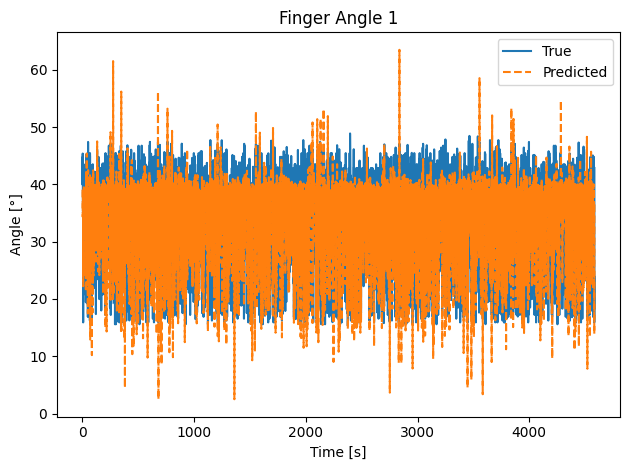

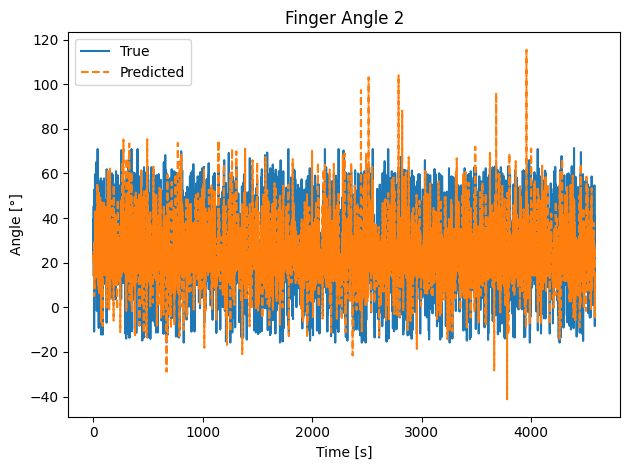

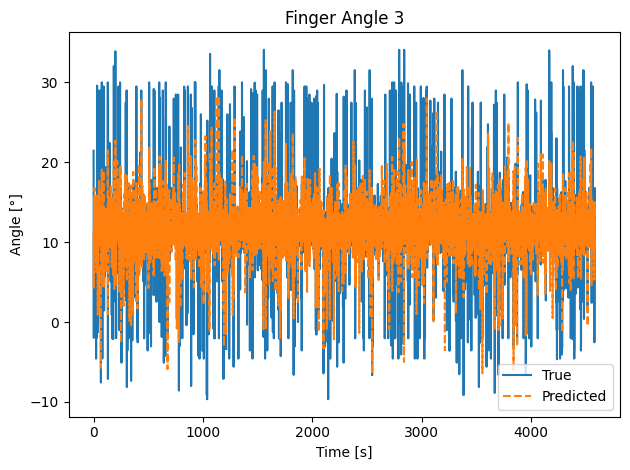

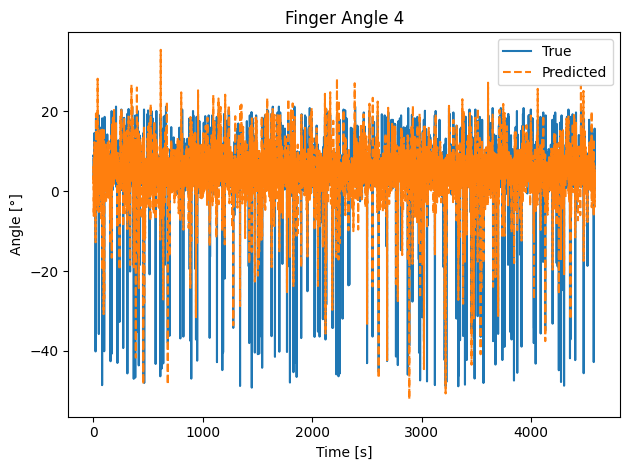

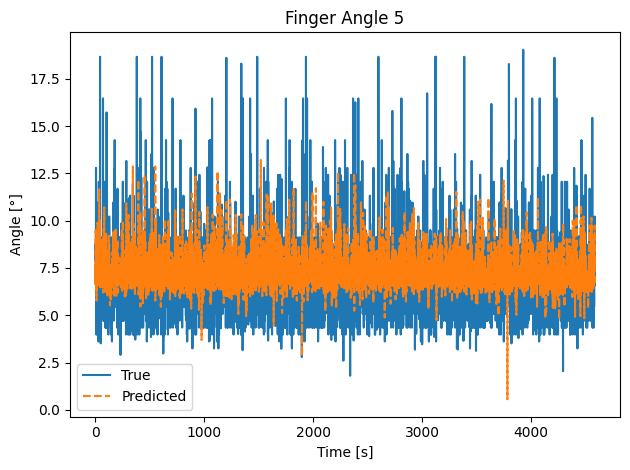

In [115]:
# Plot the true and predicted values for finger angle 3 -> label 0
#glove_data_index[3,6,8,11,14] are the labels 
# Assuming Labels_test_mean and Labels_test_pred are already defined and have 5 columns (for 5 finger angles)

for i in range(5):  # Loop over each finger angle (index 0 to 4)
    fig, ax = plt.subplots()
    ax.plot(Labels_test_mean[:, i], label="True")  # True values for finger angle i
    ax.plot(Labels_test_pred[:, i], linestyle="--", label="Predicted")  # Predicted values for finger angle i
    ax.legend()
    ax.set_title(f"Finger Angle {i + 1}")  # Set title for each plot
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Angle [°]")
    plt.tight_layout()
    plt.show()